# Tutorial 4: Extending Metrics and Plots

Use the quickstart pipeline outputs to add custom metrics and plots via the registries.

In [1]:
import torch
from pathlib import Path

from pioneerml.evaluation import (
    METRIC_REGISTRY,
    PLOT_REGISTRY,
    MetricCollection,
    register_metric,
)
from pioneerml.evaluation.plots import (
    plot_loss_curves,
    plot_multilabel_confusion_matrix,
    plot_precision_recall_curves,
    plot_roc_curves,
    register_plot,
)
from pioneerml.zenml import load_step_output
from pioneerml.zenml import utils as zenml_utils
from pioneerml.zenml.pipelines import quickstart_pipeline

zenml_client = zenml_utils.setup_zenml_for_notebook(use_in_memory=True)
print(f"ZenML initialized with stack: {zenml_client.active_stack_model.name}")
print("Initial metrics:", list(METRIC_REGISTRY))
print("Initial plots:", list(PLOT_REGISTRY))


Using ZenML repository root: /home/jack/python_projects/pioneerML
Ensure this is the top-level of your repo (.zen must live here).
ZenML initialized with stack: default
Initial metrics: ['multilabel_classification', 'regression'] ['multilabel_classification', 'regression']
Initial plots: ['loss_curves', 'multilabel_confusion', 'precision_recall', 'roc', 'regression_diagnostics'] ['loss_curves', 'multilabel_confusion', 'precision_recall', 'roc', 'regression_diagnostics']


## Register custom metric and plot

- Metric: average top-class confidence (after sigmoid) to gauge model certainty.
- Plot: class frequency bar chart from the targets to visualize imbalance.

In [2]:
@register_metric("avg_top_confidence")
def avg_top_confidence_metric(predictions, targets, **_: object) -> dict[str, float]:
    probs = torch.sigmoid(predictions).detach().cpu()
    top_conf = probs.max(dim=1).values.mean().item()
    return {"avg_top_confidence": float(top_conf)}


@register_plot("class_frequency")
def plot_class_frequency(predictions, targets, *, class_names=None, save_path=None, show=False):
    import matplotlib.pyplot as plt
    import numpy as np

    y_true = targets.detach().cpu()
    if y_true.dim() == 1 and predictions.dim() == 2 and y_true.numel() % predictions.shape[-1] == 0:
        y_true = y_true.view(-1, predictions.shape[-1])
    if y_true.dim() == 1:
        y_true = y_true.unsqueeze(0)
    freq = y_true.sum(dim=0).cpu().numpy()
    labels = class_names or [str(i) for i in range(freq.shape[0])]

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(np.arange(freq.shape[0]), freq)
    ax.set_xticks(np.arange(freq.shape[0]))
    ax.set_xticklabels(labels)
    ax.set_ylabel("Count")
    ax.set_title("Target class frequency")
    fig.tight_layout()

    if save_path is not None:
        save_path = str(save_path)
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
    if show:
        backend = plt.get_backend().lower()
        if backend.startswith("agg"):
            try:
                from IPython.display import display
                display(fig)
            except Exception:
                pass
        else:
            plt.show()
    plt.close(fig)
    return save_path

print("Registered metrics:", list(METRIC_REGISTRY))
print("Registered plots:", list(PLOT_REGISTRY))


Registered metrics: ['multilabel_classification', 'regression', 'avg_top_confidence'] ['multilabel_classification', 'regression', 'avg_top_confidence']
Registered plots: ['loss_curves', 'multilabel_confusion', 'precision_recall', 'roc', 'regression_diagnostics', 'class_frequency'] ['loss_curves', 'multilabel_confusion', 'precision_recall', 'roc', 'regression_diagnostics', 'class_frequency']


## Run quickstart pipeline and fetch outputs

The pipeline returns `(trained_module, datamodule, predictions, targets)`.

In [3]:
run = quickstart_pipeline.with_options(enable_cache=False)()
print(f"Pipeline run status: {run.status}")

trained_module = load_step_output(run, "train_module")
datamodule = load_step_output(run, "build_datamodule")
preds = load_step_output(run, "collect_predictions", output_name="output_0", index=0)
targets = load_step_output(run, "collect_predictions", output_name="output_1", index=0)

if preds is None or targets is None:
    outputs = load_step_output(run, "collect_predictions")
    if isinstance(outputs, (tuple, list)) and len(outputs) == 2:
        preds, targets = outputs

print("preds shape:", tuple(preds.shape) if preds is not None else None)
print("targets shape:", tuple(targets.shape) if targets is not None else None)


Initiating a new run for the pipeline: quickstart_pipeline.
Caching is disabled by default for quickstart_pipeline.
Using user: default
Using stack: default
  deployer: default
  orchestrator: default
  artifact_store: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step build_datamodule has started.
Step build_datamodule has finished in 0.086s.
Step build_module has started.
Step build_module has finished in 0.079s.
Step train_module has started.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | GroupClassifier   | 1.1 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.522     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

[train_module] /home/jack/virtual_environments/miniconda3/envs/pioneerml/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=15 in the DataLoader` to improve performance.

[train_module] /home/jack/virtual_environments/miniconda3/envs/pioneerml/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=15 in the DataLoader` to improve performance.



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Step train_module has finished in 1.022s.
Step collect_predictions has started.
Step collect_predictions has finished in 0.850s.
Pipeline run has finished in 2.901s.
Pipeline run status: completed
preds shape: (64, 3) (64, 3)
targets shape: (64, 3) (64, 3)


## Compute built-in + custom metrics

Use the registry to combine defaults with the new metric.

In [4]:
metric_names = ["multilabel_classification", "avg_top_confidence"]
collection = MetricCollection.from_names(metric_names)
metrics = collection(preds, targets, threshold=0.5)
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


multilabel_classification.subset_accuracy: 0.8750
multilabel_classification.precision: 0.9164
multilabel_classification.recall: 0.8788
multilabel_classification.f1: 0.8856
multilabel_classification.avg_precision: 0.9905
multilabel_classification.roc_auc: 0.9949
multilabel_classification.class/0/precision: 0.8400
multilabel_classification.class/0/recall: 0.9545
multilabel_classification.class/0/f1: 0.8936
multilabel_classification.class/1/precision: 1.0000
multilabel_classification.class/1/recall: 0.6818
multilabel_classification.class/1/f1: 0.8108
multilabel_classification.class/2/precision: 0.9091
multilabel_classification.class/2/recall: 1.0000
multilabel_classification.class/2/f1: 0.9524
avg_top_confidence.avg_top_confidence: 0.9331


## Display plots inline (no saving)

Built-in and custom plot functions are called with `show=True` so they render in the notebook.

Rendering plots inline (nothing saved)...


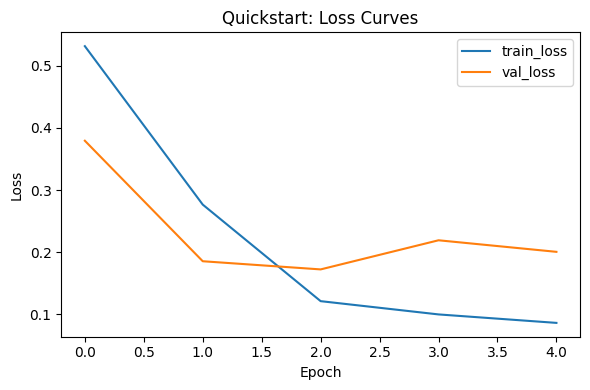

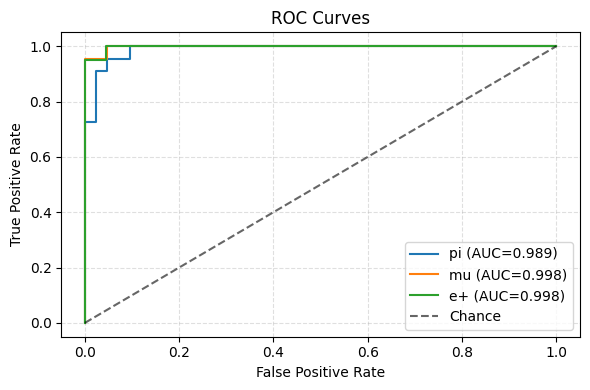

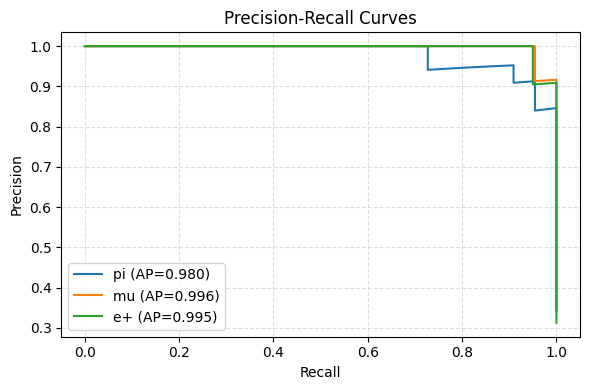

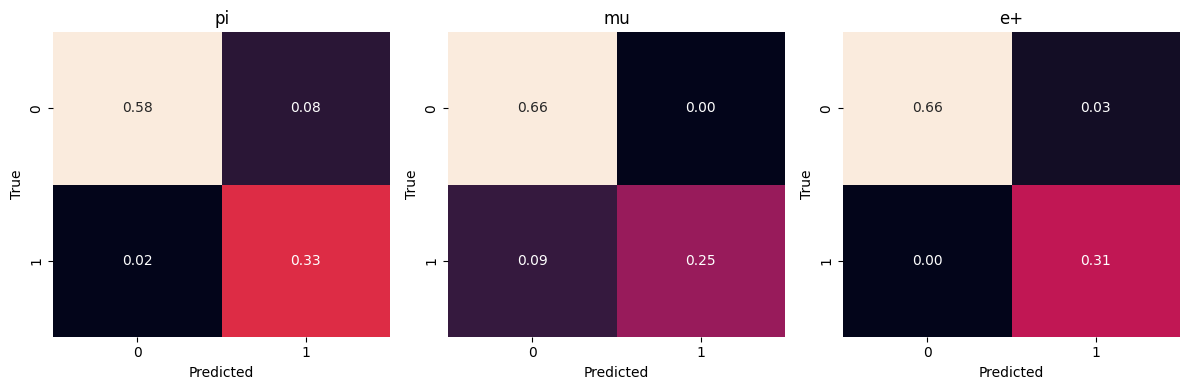

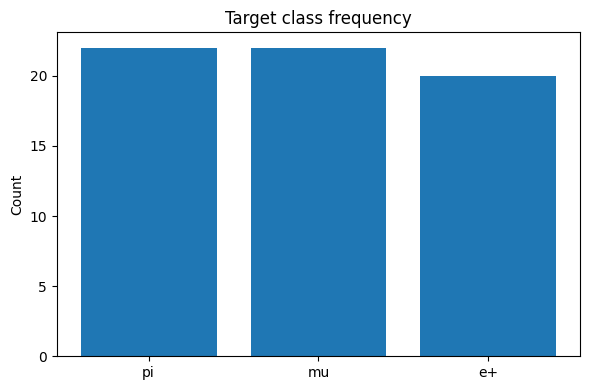

In [5]:
plot_loss_curves(
    getattr(trained_module, "train_epoch_loss_history", []),
    getattr(trained_module, "val_epoch_loss_history", []),
    title="Quickstart: Loss Curves",
    show=True,
)

plot_roc_curves(
    predictions=preds,
    targets=targets,
    class_names=["pi", "mu", "e+"],
    show=True,
)

plot_precision_recall_curves(
    predictions=preds,
    targets=targets,
    class_names=["pi", "mu", "e+"],
    show=True,
)

plot_multilabel_confusion_matrix(
    predictions=preds,
    targets=targets,
    class_names=["pi", "mu", "e+"],
    show=True,
)

PLOT_REGISTRY["class_frequency"](
    predictions=preds,
    targets=targets,
    class_names=["pi", "mu", "e+"],
    show=True,
)
